In [4]:
# Dataset Directory

dataset_folder = '/mnt/Data1/Nick/transcription_pipeline/'

Rpb1_datasets = [
    "test_data/2024-10-11/Halo552_Rpb1_embryo03"
]

test_dataset_name = dataset_folder + Rpb1_datasets[0]
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/2024-10-11/Halo552_Rpb1_embryo03


In [5]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

# Importing libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
from IPython.display import display
import emcee
import os
from warnings import warn
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox

root = tk.Tk()
root.withdraw();

`JAVA_HOME` environment variable set to /mnt/Data1/Nick/miniforge3/envs/transcription_pipeline


In [6]:
mpl.use('TkAgg')
# %matplotlib widget

In [7]:
ms2_import_previous = os.path.isdir(test_dataset_name + '/collated_dataset')
ms2_import_previous

True

In [8]:
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    import_previous=ms2_import_previous, 
)

In [14]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42113 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>


In [13]:
client.restart()


AttributeError: 'NoneType' object has no attribute 'restart'

In [12]:
client.shutdown()

In [15]:
print(client.dashboard_link)

http://127.0.0.1:42113/status


In [9]:
nuclear_tracking_previous = os.path.isdir(test_dataset_name + '/nuclear_analysis_results')
nuclear_tracking_previous

True

In [10]:
if nuclear_tracking_previous:
    # Load nuclear tracking results
    print('Load from previous nuclear tracking results')
    
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do nuclear tracking and save the results
    print('Do nuclear tracking for the dataset')
    
    nuclear_tracking = nuclear_pipeline.Nuclear(
        data=dataset.channels_full_dataset[0],
        global_metadata=dataset.export_global_metadata[0],
        frame_metadata=dataset.export_frame_metadata[0],
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        search_range_um=1.5,
        stitch=False,
        stitch_max_distance=4,
        stitch_max_frame_distance=2,
        client=client,
        keep_futures=False,
    )
    
    nuclear_tracking.track_nuclei(
            working_memory_mode="zarr",
            working_memory_folder=test_dataset_name,
            trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
        )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
    nuclear_tracking.save_results(
            name_folder=test_dataset_name, save_array_as=None
        )

Load from previous nuclear tracking results


In [11]:
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)

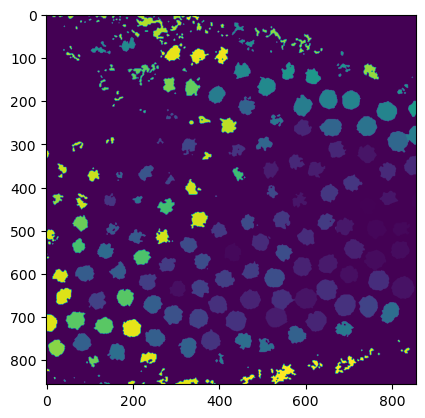

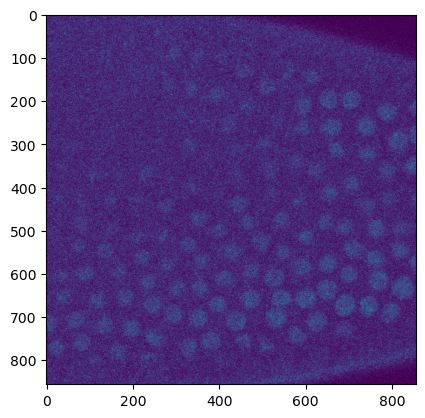

In [12]:
%matplotlib inline
z_slice = 4
time_frame = 22

plt.imshow(nuclear_tracking.reordered_labels[time_frame,z_slice, :,:])

# Plot same frame and z slice of dataset
plt.figure()
plt.imshow(dataset.channels_full_dataset[0][time_frame, z_slice, :, :])

plt.show()

In [85]:
dataset.channels_full_dataset[0][0,8,205,200]

5

In [82]:
nuclear_dataframe = nuclear_tracking.mitosis_dataframe
nuclear_dataframe[nuclear_dataframe['particle'] == 51]

,label,z,y,x,nuclear_intensity_mean,nuclear_intensity_stdev,frame,original_frame,t_s,t_frame,nuclear_cycle,y_pixel,x_pixel,particle,v_z,v_y,v_x,parent
50,53,6.455082,43.322936,46.467052,3.793333,2.171608,37,37,1055.132999,37,14,400.991387,430.092912,51,-0.017921,0.084399,0.063156,<NA>
226,42,6.473003,43.238537,46.403896,3.746777,2.162697,36,36,1027.276999,36,14,400.210199,429.508347,51,-0.017921,0.084399,0.063156,<NA>
428,50,6.073697,43.223041,46.432365,3.717534,2.159484,35,35,999.417000,35,14,400.066771,429.771852,51,0.190693,0.049948,0.017344,<NA>
592,29,5.765097,43.368581,46.592954,3.691271,2.125227,34,34,969.816999,34,14,401.413876,431.258246,51,0.353953,-0.065022,-0.094529,<NA>
768,13,5.066987,43.563939,46.973930,3.689412,2.149073,33,33,941.956999,33,14,403.222078,434.784508,51,0.503355,-0.170449,-0.270783,<NA>
962,11,4.916841,43.660934,47.385762,3.663829,2.158390,32,32,912.356998,32,14,404.119849,438.596365,51,0.424128,-0.146176,-0.396404,<NA>
1154,13,4.444310,43.759682,47.537837,3.580397,2.113254,31,31,884.500999,31,14,405.033856,440.003960,51,0.311339,-0.097872,-0.281954,<NA>
1354,24,4.589714,43.952917,47.761494,3.475903,2.070101,30,30,856.636999,30,14,406.822408,442.074100,51,0.163563,-0.145992,-0.187866,<NA>
1548,27,4.409929,44.123703,48.001933,3.303815,1.993743,29,29,828.764999,29,14,408.403184,444.299569,51,0.017190,-0.182010,-0.232048,<NA>
1745,34,4.368355,44.396180,48.329742,3.250432,1.944004,28,28,800.868999,28,14,410.925196,447.333726,51,0.110680,-0.221632,-0.284124,<NA>


In [ ]:
def plot_nucleus_region(df, data, mask, nuclear_label, window_size=20):
    """
    Plots the region enclosing the nucleus at a given time frame and z-slice.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing centroid coordinates ('time', 'z', 'y', 'x') in pixels.
    data (np.ndarray): 4D dataset with shape (t, z, y, x).
    time_frame (int): The time frame to analyze.
    z_slice (int): The z-slice to visualize.
    window_size (int): Size of the region around the nucleus to extract.
    """
    # Extract the time frames when the spot exists
    nucleus = df[df['particle'] == nuclear_label]
    
    if nucleus.empty:
        raise ValueError(f"No nucleus found for label {nuclear_label}.")
    
    t_frames = np.sort(nucleus['t_frame'])
    
    # Get the y and x coordinates of the nucleus centroid
    y_centroid = int(nucleus['y_pixel'].values[0])
    x_centroid = int(nucleus['x_pixel'].values[0])

    # Define the bounding box around the centroid
    y_start = max(0, y_centroid - window_size // 2)
    y_end = min(data.shape[2], y_centroid + window_size // 2)
    x_start = max(0, x_centroid - window_size // 2)
    x_end = min(data.shape[3], x_centroid + window_size // 2)
    
    # Extract the region around the nucleus
    region = data[t_frame, z_slice, y_start:y_end, x_start:x_end]
    
    # Plot the region
    plt.figure(figsize=(6, 6))
    plt.imshow(region, cmap='gray', interpolation='none')
    plt.title(f"Time Frame: {t_frame}, Z-Slice: {z_slice}, Nucleus Centroid: ({y_centroid}, {x_centroid})")
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame containing centroids and `data` is your 4D dataset
# df.columns = ['time', 'z', 'y', 'x']
# data.shape = (t, z, y, x)

time_frame = 5  # Time frame to plot
z_slice = 10    # Z-slice to plot
plot_nucleus_region(df, data, time_frame, z_slice, window_size=30)


In [56]:
mask = np.array(nuclear_tracking.reordered_labels)
nucleus_label = int(51)
mask = mask.astype(int)

nucleus_slices = np.argwhere(mask == nucleus_label)

# print(np.min(nucleus_slices[0, :, :, :]))

print(np.min(nucleus_slices[:, 0]))




22


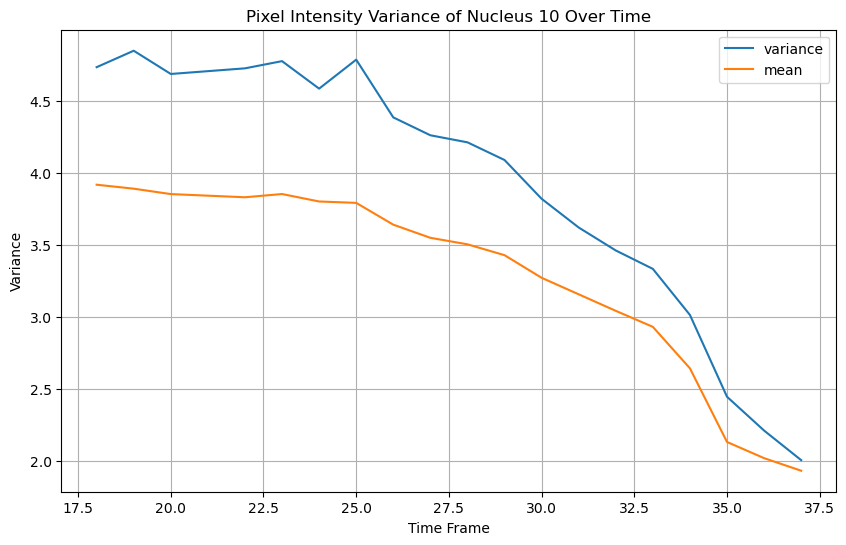

In [107]:
import numpy as np
import matplotlib.pyplot as plt

def plot_nucleus_intensity_variance(df, data, mask, nuclear_label):
    """
    Plots the pixel intensity variance of a chosen nucleus over time using the mask.

    Parameters:
    df (pd.DataFrame): DataFrame containing centroid coordinates ('time', 'z', 'y', 'x') in pixels.
    data (np.ndarray): 4D dataset with shape (t, z, y, x).
    mask (np.ndarray): 3D mask with labeled nuclei.
    nuclear_label (int): Label of the nucleus to analyze.
    """
    # Extract the time frames when the nucleus exists
    nucleus = df[df['particle'] == nuclear_label]
    
    if nucleus.empty:
        raise ValueError(f"No nucleus found for label {nuclear_label}.")
    
    t_frames = np.sort(nucleus['t_frame'].unique())
    
    variances = nucleus['nuclear_intensity_stdev'].to_numpy()**2
    mean = nucleus['nuclear_intensity_mean'].to_numpy()
    
    # Plot the variance over time
    plt.figure(figsize=(10, 6))
    plt.plot(t_frames, variances, label='variance')
    plt.plot(t_frames, mean, label='mean')
    plt.title(f'Pixel Intensity Variance of Nucleus {nuclear_label} Over Time')
    plt.xlabel('Time Frame')
    plt.ylabel('Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame containing centroids and `data` is your 4D dataset
# df.columns = ['time', 'z', 'y', 'x']
# data.shape = (t, z, y, x)

nucleus_label =   # Label of the nucleus to analyze
plot_nucleus_intensity_variance(nuclear_dataframe, 
                                dataset.channels_full_dataset[0], 
                                nuclear_tracking.reordered_labels, 
                                nucleus_label)


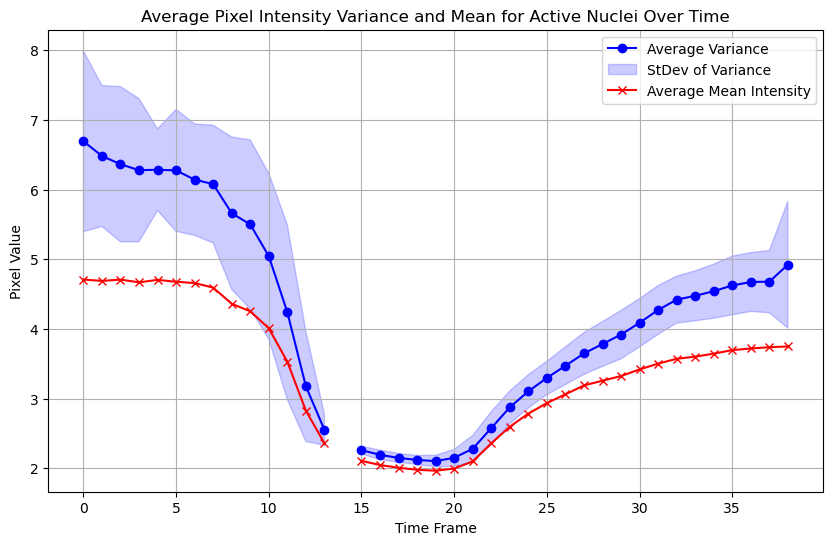

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def plot_timewise_nucleus_intensity_variance_with_sem(df, data, mask, start_time, end_time):
    """
    Plots the mean pixel intensity variance and mean intensity over time,
    with the standard error of the mean (SEM) for the variance shown as a shaded region.

    Parameters:
    df (pd.DataFrame): DataFrame containing centroid coordinates ('time', 'z', 'y', 'x') in pixels.
    data (np.ndarray): 4D dataset with shape (t, z, y, x).
    mask (np.ndarray): 3D mask with labeled nuclei.
    start_time (int): Start time frame.
    end_time (int): End time frame.
    """
    timepoints = np.arange(start_time, end_time + 1)
    mean_variances = []
    sem_variances = []  # Standard error of the mean for variances
    mean_intensities = []
    
    for t in timepoints:
        # Filter for nuclei active at the current time point
        nuclei_at_t = df[df['t_frame'] == t]
        
        if nuclei_at_t.empty:
            mean_variances.append(np.nan)
            sem_variances.append(np.nan)
            mean_intensities.append(np.nan)
            continue
        
        # Calculate variance and mean intensity for all active nuclei at this time
        variances_at_t = (nuclei_at_t['nuclear_intensity_stdev']**2).to_numpy()
        intensities_at_t = nuclei_at_t['nuclear_intensity_mean'].to_numpy()
        
        # Average over all active nuclei
        mean_variances.append(np.mean(variances_at_t))
        mean_intensities.append(np.mean(intensities_at_t))
        
        # Calculate SEM for the variance
        sem_variances.append(np.std(variances_at_t))# / np.sqrt(len(variances_at_t)))
    
    # Plot mean variance with SEM as shaded region
    plt.figure(figsize=(10, 6))
    plt.plot(timepoints, mean_variances, label='Average Variance', color='blue', marker='o')
    plt.fill_between(timepoints,
                     np.array(mean_variances) - np.array(sem_variances),
                     np.array(mean_variances) + np.array(sem_variances),
                     color='blue', alpha=0.2, label='StDev of Variance')
    
    # Plot mean intensity over time
    plt.plot(timepoints, mean_intensities, label='Average Mean Intensity', color='red', marker='x')
    
    # Plot details
    plt.title(f'Average Pixel Intensity Variance and Mean for Active Nuclei Over Time')
    plt.xlabel('Time Frame')
    plt.ylabel('Pixel Value')
    plt.legend()
    plt.grid(True)
    plt.show()


    
start_frame=0
end_frame=38
plot_timewise_nucleus_intensity_variance_with_sem(nuclear_dataframe, 
                                dataset.channels_full_dataset[0], 
                                nuclear_tracking.reordered_labels, 
                                start_frame,
                                end_frame)
